(3684, 4912, 3)


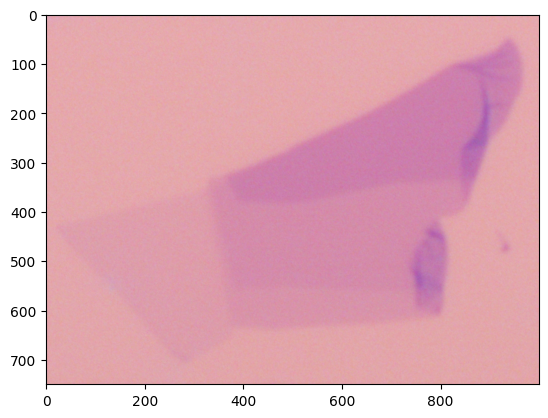

In [2]:
"""A script to plot an image in a pyplot figure

    Hover mouse over pyplot figure to determine the max/min
    values of x and y that totally enclose the flake.

    Enter those values for the indices of the plotted image,
    then run script again to determine regions of substrate.
    """

import matplotlib.pyplot as plt
import cv2

img_loc = './Raw Images/Fig_1a.jpg' ## Sample flake image location
img = cv2.imread(img_loc, cv2.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(cv2.cvtColor(img[1100:1850,2300:3300], cv2.COLOR_BGR2RGB)) ## crop image with indices

plt.show()


Manually inspect background reduction, then close figures.


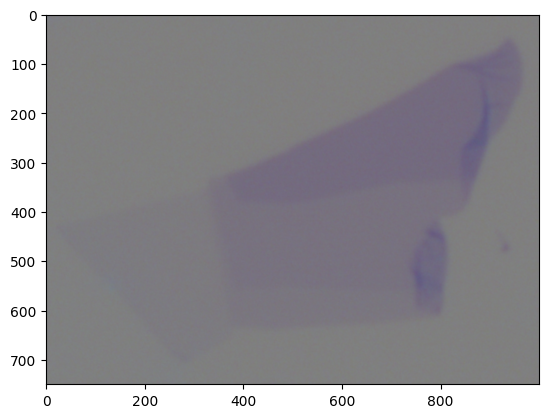

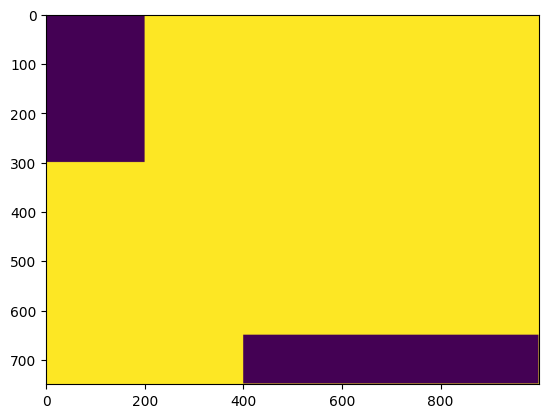

Image for KHGR002 3D1 loaded and pre-processed.
Mean-shift algorithm start.
Cycle 1 of mean-shifting completed.
Cycle 2 of mean-shifting completed.
Cycle 3 of mean-shifting completed.
Cycle 4 of mean-shifting completed.
Cycle 5 of mean-shifting completed.
Cycle 6 of mean-shifting completed.
Cycle 7 of mean-shifting completed.
Cycle 8 of mean-shifting completed.
Cycle 9 of mean-shifting completed.
Cycle 10 of mean-shifting completed.
Cycle 11 of mean-shifting completed.
Cycle 12 of mean-shifting completed.
Cycle 13 of mean-shifting completed.
Cycle 14 of mean-shifting completed.
Cycle 15 of mean-shifting completed.
Cycle 16 of mean-shifting completed.
Cycle 17 of mean-shifting completed.
Cycle 18 of mean-shifting completed.
Cycle 19 of mean-shifting completed.
Cycle 20 of mean-shifting completed.
Optimization achieved after 20 cycles.
69 mean points.
DBSCAN algorithm start.
DBSCAN completed after 68 cycles.
Mean Point Grouping: [0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 2 2 2 2 2 

/tmp/ipykernel_168322/1056337088.py:332: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cluster_prob[nn,kk] = calc_num/calc_denom


Cycle 1 of GMM completed
Cycle 2 of GMM completed
Cycle 3 of GMM completed
Cycle 4 of GMM completed


/tmp/ipykernel_168322/1056337088.py:42: RuntimeWarning: overflow encountered in exp
  return (((2*np.pi)**3) * np.linalg.det(cov) * np.exp(make_bra(data-mean).dot((np.linalg.inv(cov)).dot(make_ket(data-mean)))))**(-0.5)


Cycle 5 of GMM completed
Cycle 6 of GMM completed
Cycle 7 of GMM completed
Cycle 8 of GMM completed
Cycle 9 of GMM completed
Cycle 10 of GMM completed
Cycle 11 of GMM completed
Cycle 12 of GMM completed
Cycle 13 of GMM completed
Cycle 14 of GMM completed
Cycle 15 of GMM completed
Cycle 16 of GMM completed
Cycle 17 of GMM completed
Cycle 18 of GMM completed
Cycle 19 of GMM completed
Cycle 20 of GMM completed
Cycle 21 of GMM completed
Cycle 22 of GMM completed
Cycle 23 of GMM completed
Cycle 24 of GMM completed
Cycle 25 of GMM completed
Cycle 26 of GMM completed
Cycle 27 of GMM completed
Cycle 28 of GMM completed
Cycle 29 of GMM completed
Cycle 30 of GMM completed
Cycle 31 of GMM completed
Cycle 32 of GMM completed
Cycle 33 of GMM completed
Cycle 34 of GMM completed
Cycle 35 of GMM completed
Cycle 36 of GMM completed
Cycle 37 of GMM completed
Cycle 38 of GMM completed
Cycle 39 of GMM completed
Cycle 40 of GMM completed
Cycle 41 of GMM completed
Cycle 42 of GMM completed
Cycle 43 of GMM c

In [ ]:
"""Process optical images of thin flakes to distinguish layer thicknesses."""

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from read_npz import npz2dict
import os
import time
import cv2
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt


def line2d(x, y, coeffs=[1]*3, return_coeff=False):
    """Returns the result of a 2D quadratic, or returns the coefficients"""
    a0 = (x*0+1)*coeffs[0]
    a1 = x*coeffs[1]
    a2 = y*coeffs[2]
    if return_coeff:
        return a0, a1, a2
    else:
        return a0+a1+a2

def make_ket(lst):
    """Turn a list of values into a ket (Dirac notation)"""
    return (np.array(lst)).reshape(-1,1)

def make_bra(lst):
    """Turn a list of values into a bra (Dirac notation)"""
    return (np.array(lst)).reshape(1,-1)

def multivar_gauss(data, mean, cov, cluster_count):
    """Multivariate Gaussian distribution function for GMM calculation.

        data: [blue value, green value, red value]
        mean: mean vector of one cluster
        cov: covariance matrix of one cluster
        cluster_count: number of clusters"""
    data = np.array(data)
    mean = np.array(mean)
    return (((2*np.pi)**3) * np.linalg.det(cov) * np.exp(make_bra(data-mean).dot((np.linalg.inv(cov)).dot(make_ket(data-mean)))))**(-0.5)

def confellipsoid(rad, cent_x, cent_y, cent_z, covariance, res=20, conf=7.815):
    """Creates a confidence ellipsoid based on conf parameter."""

    ## Initial sphere
    u = np.linspace(0, 2*np.pi, res) # Azimuthal angle phi
    v = np.linspace(0, np.pi, res) # Polar angle theta
    x_ = np.outer(np.cos(u), np.sin(v))
    y_ = np.outer(np.sin(u), np.sin(v))
    z_ = np.outer(np.ones(np.size(u)), np.cos(v))
    p = np.stack((x_,y_,z_), axis=2)
    ## Determine confidence matrix transformation
    eigval, eigvec = la.eig(covariance)
    conftrans = np.matmul(np.matmul(eigvec, np.diag(np.sqrt(conf*eigval))), la.inv(eigvec))
    ## Make ellipsoids
    rad_size = np.ones(rad.shape)
    offset = np.array([cent_x, cent_y, cent_z])
    cov_rot = np.tile(conftrans, (res,res,1,1))
    ell_inter = rad_size*np.matmul(cov_rot, p[:,:,:,np.newaxis],
                axes=[(-2,-1),(-2,-1),(-2,-1)]).reshape(res,res,3)
    elli = ell_inter + np.tile(offset, (res,res,1))
    return elli


def training(img_file, flake_name, crop, masking, out_file,
             comp_rate=100, density=8, min_clusters=0,
             max_clusters=100, convergence_param=0.0001):
    """
    Clusters pixels of like-color in flake image "img_file" and saves the
    clusters to the catalog "out_file".

    Parameters
    ----------
    img_file : str
        Location of sample image file. (i.e., "...\\RSGR001\\All\\3A1.jpg")
    flake_name : str
        Name of sample image. (i.e., "RSGR001 3A1")
    crop : list of ints of form [miny, maxy, minx, maxx]
        Region to crop sample image to. (i.e., [1750,2550, 2100,2850])
    masking : list of list of ints of form [[miny1,maxy1,minx1,maxx1], ...]
        Regions of substrate to fit background. Indices relative to cropped
        image. (i.e., [[200,-1, 0,175], [0,200, 500,-1], [700,-1, 500,-1]])
    out_file : str
        Location of catalog npz file for the same material/substrate as sample.
        (i.e., "...\\Graphene_on_SiO2_catalog.npz")
    comp_rate : int [default: 100]
        Factor in calculating the compression of the normalized image.
        Compression is comp = sqrt(pixels in cropped image)/comp_rate
    density : int [default: 8]
        density^3 gives the number of initial mean points.
    min_clusters : int [default: 0]
        Set minimum number of GMM clusters to fit to.
    max_clusters : int [default: 100]
        Set maximum number of GMM clusters to fit to.
    convergence_param : float [default: 0.0001]
        Parameter to determine how precisely to fit the GMM clusters.
    """

    tic = time.perf_counter()

        ## Import and pre-processing
    ## Image import
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)

    ## Bilateral filtering
    img_bl = (img[crop[0]:crop[1], crop[2]:crop[3]]).astype(np.float32)/256
    for ii in range(1):
        img_bl = cv2.bilateralFilter(img_bl,2,1,1)

    mask = np.ones(img_bl[:,:,0].shape)
    for reg in masking:
        mask[reg[0]:reg[1], reg[2]:reg[3]] = 0

    ## Fit to background based on pixels outside the flake.
    y_dim, x_dim, _ = img_bl.shape
    R = img_bl[:,:,0].flatten()
    G = img_bl[:,:,1].flatten()
    B = img_bl[:,:,2].flatten()
    X_, Y_ = np.meshgrid(np.arange(x_dim),np.arange(y_dim))
    X = X_.flatten()
    Y = Y_.flatten()
    sub_loc = ((mask.flatten())==0).nonzero()[0]
    Rsub = R[sub_loc]
    Gsub = G[sub_loc]
    Bsub = B[sub_loc]
    Xsub = X[sub_loc]
    Ysub = Y[sub_loc]

    Asub = np.array([*line2d(Xsub, Ysub, return_coeff=True)]).T

    Rcop,_,_,_ = np.linalg.lstsq(Asub, Rsub, rcond=None)
    Gcop,_,_,_ = np.linalg.lstsq(Asub, Gsub, rcond=None)
    Bcop,_,_,_ = np.linalg.lstsq(Asub, Bsub, rcond=None)

    Rfitp = line2d(X, Y, coeffs=[*Rcop])
    Gfitp = line2d(X, Y, coeffs=[*Gcop])
    Bfitp = line2d(X, Y, coeffs=[*Bcop])

    img_poly = np.dstack([(R-Rfitp+1).reshape(y_dim,x_dim)/2,
                          (G-Gfitp+1).reshape(y_dim,x_dim)/2,
                          (B-Bfitp+1).reshape(y_dim,x_dim)/2])

    print('Manually inspect background reduction, then close figures.')
    plt.figure()
    plt.imshow(img_poly)
    plt.figure()
    plt.imshow(mask)
    plt.show() ## Displays for manual inspection for continuing.

    ## Another round of bilateral filtering
    img_bl2 = img_poly.astype(np.float32)
    for ii in range(3):
        img_bl2 = cv2.bilateralFilter(img_bl2,2,0.5,1)

    ## Cropping and compression
    img_size = img_bl2.shape
    comp =  int(((img_size[0]*img_size[1])**(0.5))/comp_rate) ## Compress image by 'comp'
    img_proc = (img_bl2[0::comp, 0::comp])
    color = img_proc.flatten().reshape(-1,3)

    print(f"Image for {flake_name} loaded and pre-processed.")

    image_size = img_proc.shape

    R = img_proc[:,:,0].flatten()
    G = img_proc[:,:,1].flatten()
    B = img_proc[:,:,2].flatten()

    BGRmin = np.amin([B,G,R], axis=1).astype(float)
    BGRmax = np.amax([B,G,R], axis=1).astype(float)


        ## Meanshift
    ## Initalize array of starting points (regularly-spaced points in BGR space)
    axes = np.linspace(BGRmin, BGRmax, density)
    mesh = np.meshgrid(axes[:,0], axes[:,1], axes[:,2]) ## Initial array

    ## Following 5 lines are the dynamic elements of mean-shifting
    meanB = mesh[0].flatten()
    meanG = mesh[1].flatten()
    meanR = mesh[2].flatten() ## All arrays of length density^3
    mean_count = np.zeros(len(meanB)) ## Number of pixels within a mean point's sphere
    mp_life = np.full(len(meanB), True)

    diag = np.sqrt(np.sum((BGRmax - BGRmin)**2))/(density - 1)
    epsilon = diag/3 ## Radius of each point's sphere of posession (OPT)

    print("Mean-shift algorithm start.")

    max_cycles = 500 ## Max cycles until force cutoff
    for cycle in range(max_cycles):
        if not np.any(mp_life): ## If all mp's are turned off, end the cycle.
            print("Optimization achieved after {} cycles.".format(cycle))
            break
        kill_index = []
        for nn in range(len(meanB)): ## For each mean point...
            if mp_life[nn]: ## Check if its optimum has been reached
                counter = 0 ## Tracks how many pixels are within nn's sphere
                listB = []
                listG = []
                listR = [] ## Housing for BGR values of pixels within nn's sphere
                for ii in range(image_size[1]):
                    for jj in range(image_size[0]): ## For each pixel in img_proc...
                        if epsilon**2 >= ((img_proc[jj,ii,0]-meanR[nn])**2 + (img_proc[jj,ii,1]-meanG[nn])**2 + (img_proc[jj,ii,2]-meanB[nn])**2):
                            counter += 1 ## Increment counter
                            listR.append(img_proc[jj,ii,0])
                            listG.append(img_proc[jj,ii,1])
                            listB.append(img_proc[jj,ii,2])
                if counter == 0:
                    kill_index.append(nn) ## Put nn on chopping block
                elif counter >= mean_count[nn]: ## If more pixels within nn's sphere than before...
                    if meanB[nn] == np.mean(listB) and meanG[nn] == np.mean(listG) and meanR[nn] == np.mean(listR): ## If the position doesn't change, it's optimized.
                        mp_life[nn] = False
                    else:
                        meanB[nn] = np.mean(listB)
                        meanG[nn] = np.mean(listG)
                        meanR[nn] = np.mean(listR) ## Calculate new center for nn (this is the mean-shift part!)
                        mean_count[nn] = counter ## Update mean_count
                else: ## If pixel count went down, turn off this mean point
                    mp_life[nn] = False
        ## Kill off empty mean points (probably more concise if I used dictionaries)
        meanB = np.delete(meanB, kill_index)
        meanG = np.delete(meanG, kill_index)
        meanR = np.delete(meanR, kill_index)
        mean_count = np.delete(mean_count, kill_index)
        mp_life = np.delete(mp_life, kill_index)

        print("Cycle {} of mean-shifting completed.".format(cycle+1))

        if cycle+1 == max_cycles:
            print("Optimization not achieved after {} cycles".format(max_cycles))

    ## Consolidation of optimized mean points
    thresh = image_size[1]*image_size[0]/175
    outliers = (mean_count<thresh).nonzero()[0] ## Indices of mean points with more than x data points near them.
    meanB_no = np.delete(meanB, outliers) ## Not enough data points in thier spheres? They're outliers, drop'em.
    meanG_no = np.delete(meanG, outliers)
    meanR_no = np.delete(meanR, outliers)
    k_mp = len(meanB_no) ## Number of mean points
    print("{} mean points.".format(k_mp))


        ## DBSCAN to consolidate further
    mp_visit = np.full(k_mp, False) ## Tracks whether a mean point has been visited.
    eps2 = epsilon/2 ## Some radius to reach the next point (OPT)
    mp_grouping = np.full(k_mp, -1) ## Keeps track of what group each mp belongs to.
    group_number = 0

    print("DBSCAN algorithm start.")
    cycle = 0
    while not np.all(mp_visit): ## Until all mean points are visited,...
        if not group_number in mp_grouping: ## If group_number has no group members,...
            kk = (mp_visit==False).nonzero()[0][0] ## make the first non-visited mp a member.
            mp_visit[kk] = True
            mp_grouping[kk] = group_number
        for nn in range(k_mp): ## (Could possibly speed up by skipping the mp's that have been assigned to previous groups.)
            if nn != kk:
                if eps2**2 >= (meanB_no[nn]-meanB_no[kk])**2 + (meanG_no[nn]-meanG_no[kk])**2 + (meanR_no[nn]-meanR_no[kk])**2:
                    mp_grouping[nn] = group_number ## Add nn to group_number.
        group_indices = (mp_grouping==group_number).nonzero()[0] ## Indices of group_number members
        if not np.all(mp_visit[group_indices]): ## Check if an mp in group_number hasn't been visited
            kk = group_indices[(mp_visit[group_indices]==False).nonzero()[0][0]] ## First non-visited mp in group_visit gets visited.
            mp_visit[kk] = True
        else:
            group_number += 1
        cycle += 1

    print(f"DBSCAN completed after {cycle} cycles.")
    print(f"Mean Point Grouping: {mp_grouping}")


    ## Once the mean points have been grouped, average the mean points to get
    ## the k points about which GMM will be applied.

    print("Initializing GMM algorithm.")
    ## Initialize means
    GMMB = []
    GMMG = []
    GMMR = []
    for nn in range(group_number+1):
        if nn in mp_grouping:
            GMMB.append(np.mean(meanB_no[(mp_grouping==nn).nonzero()[0]]))
            GMMG.append(np.mean(meanG_no[(mp_grouping==nn).nonzero()[0]]))
            GMMR.append(np.mean(meanR_no[(mp_grouping==nn).nonzero()[0]]))

    cluster_count = len(GMMB) ## Number of data clusters
    pixel_count = len(B) ## Number of pixels

    if cluster_count < min_clusters:
        GMMB = np.append(GMMB, np.random.random(min_clusters-cluster_count))
        GMMG = np.append(GMMG, np.random.random(min_clusters-cluster_count))
        GMMR = np.append(GMMR, np.random.random(min_clusters-cluster_count))
        cluster_count = min_clusters
    elif cluster_count > max_clusters:
        cluster_diff = cluster_count - max_clusters
        GMMB = GMMB[:-cluster_diff]
        GMMG = GMMG[:-cluster_diff]
        GMMR = GMMR[:-cluster_diff]
        cluster_count = max_clusters

    print(f"Fitting to {cluster_count} clusters")

    ## Initialize covariance matrices
    covariance = np.empty((cluster_count,3,3)) ## Covariance matrices for every GMM centroid.
    for kk in range(cluster_count):
        cov_intermediate = np.zeros((3,3))
        for nn in range(pixel_count):
            ket = make_ket([B[nn]-GMMB[kk], G[nn]-GMMG[kk], R[nn]-GMMR[kk]])
            bra = make_bra([B[nn]-GMMB[kk], G[nn]-GMMG[kk], R[nn]-GMMR[kk]])
            cov_intermediate += ket.dot(bra)
        covariance[kk] = cov_intermediate/pixel_count

    ## Initialize weightings
    weight = np.full((cluster_count), 1/cluster_count) ## Assume all clusters are weighted equally.
    weight_differ = weight.copy()

    ## Expectation Maximization algorithm
    print("GMM algorithm start")
    cycle = 0
    max_cycles = 1001
    while cycle < max_cycles:
        ## Expectation:
        cluster_prob = np.empty((pixel_count, cluster_count)) ## Probability each pixel belongs to each cluster.
        for kk in range(cluster_count):
            for nn in range(pixel_count):
                calc_num = weight[kk]*multivar_gauss([B[nn],G[nn],R[nn]], [GMMB[kk],GMMG[kk],GMMR[kk]], covariance[kk], cluster_count)
                calc_denom = 0
                for ll in range(cluster_count):
                    calc_denom += weight[ll]*multivar_gauss([B[nn],G[nn],R[nn]], [GMMB[ll],GMMG[ll],GMMR[ll]], covariance[ll], cluster_count)
                cluster_prob[nn,kk] = calc_num/calc_denom
        if cycle == max_cycles - 1:
            break

        ## Maximization:
        for kk in range(cluster_count):
            prob_sum = 0
            mean_sum = np.zeros(3)
            cov_sum = np.zeros((3,3))

            for nn in range(pixel_count):
                if not np.isnan(cluster_prob[nn,kk]):
                    prob_sum += cluster_prob[nn,kk]
                    mean_sum += cluster_prob[nn,kk] * np.array([B[nn],G[nn],R[nn]])
                    cov_sum += cluster_prob[nn,kk] * (make_ket([B[nn]-GMMB[kk], G[nn]-GMMG[kk], R[nn]-GMMR[kk]])).dot(make_bra([B[nn]-GMMB[kk], G[nn]-GMMG[kk], R[nn]-GMMR[kk]]))

            weight[kk] = prob_sum/pixel_count
            GMMB[kk] = mean_sum[0]/prob_sum
            GMMG[kk] = mean_sum[1]/prob_sum
            GMMR[kk] = mean_sum[2]/prob_sum
            covariance[kk] = cov_sum/prob_sum

        cycle += 1

        if np.all(np.abs(weight - weight_differ) < convergence_param):
            print("Optimization achieved after {} cycles".format(cycle))
            break

        print("Cycle {} of GMM completed".format(cycle))

        tac = time.perf_counter()
        if (tac - tic) > 5*60*60:
            print("TIMEOUT: Longer than 5 hours.")
            break
        weight_differ = weight.copy()

    print("GMM completed.")

    ## Give each pixel a home
    nearest_cluster = np.empty(pixel_count)
    for nn in range(pixel_count):
        nearest_cluster[nn] = (cluster_prob[nn]==np.amax(cluster_prob[nn])).nonzero()[0]

    layer_image = nearest_cluster.reshape(image_size[0], image_size[1])


    ## Make ellipsoids for each GMM cycle of interest
    ellipsoids = {}
    for kk in range(cluster_count):
        ellipsoids[f'{kk}'] = confellipsoid(weight[kk],
                                        GMMB[kk],
                                        GMMG[kk],
                                        GMMR[kk],
                                        covariance[kk])

    cmap = mpl.cm.get_cmap('viridis')
    elli_color = [cmap(ii/cluster_count, alpha=0.25) for ii in range(cluster_count)]


        ## Export and Display
    try:
        in_file_dict = npz2dict(out_file)
    except FileNotFoundError:
        print(f'Created file {out_file}') ## Will be created during np.savez step.
        in_file_dict = {}
        pass
    in_file_dict[flake_name + ' weights'] = weight
    in_file_dict[flake_name + ' blue means'] = GMMB
    in_file_dict[flake_name + ' green means'] = GMMG
    in_file_dict[flake_name + ' red means'] = GMMR
    in_file_dict[flake_name + ' covariance'] = covariance


    toc = time.perf_counter()


    fig1 = plt.figure() ## Scatter plot of data points, colored according to nearest GMM fit.
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.scatter(B, G, R, c=nearest_cluster, s=0.5, marker=',')
    ax1.set_xlabel('Blue')
    ax1.set_ylabel('Green')
    ax1.set_zlabel('Red')

    fig2 = plt.figure() ## 95% confidence ellipsoids of GMM fits.
    ax2 = fig2.add_subplot(111, projection='3d')
    for kk in ellipsoids:
        ax2.plot_surface(ellipsoids[kk][:,:,0],
                         ellipsoids[kk][:,:,1],
                         ellipsoids[kk][:,:,2],
                         color=elli_color[int(kk)])
    ax2.set_xlabel('Blue')
    ax2.set_ylabel('Green')
    ax2.set_zlabel('Red')

    fig3, ax3 = plt.subplots() ## False image of sample, colored based on GMM fit.
    ax3.imshow(layer_image)

    print("{} seconds to run.".format(toc-tic))

    plt.show(block=False)
    thickness = []
    for ii in range(cluster_count):
        thickness.append(int(input(f'How thick is cluster {ii}?: ')))
    in_file_dict[flake_name + ' cluster thicknesses'] = np.array(thickness)

    keep = input('Keep this clustering? (True/False): ')
    if keep=='True':
        try:
            os.remove(out_file)
        except FileNotFoundError:
            pass
        with open(out_file, 'wb') as f:
            np.savez(f, **in_file_dict)
        print(f'Clustering data saved to {out_file}.')
        print('Training complete. Close pyplot figures to finish.')
    else:
        print('Clustering rejected. Check parameters and run script again.')

    plt.show(block=True)

args = {'img_file': "./Raw Images/Fig_1a.jpg",
        'flake_name': "KHGR002 3D1",
        'crop': [1100,1850,2300,3300],
        'masking': [[0,300, 0,200], [650,-1, 400,-1]],
        'out_file': "./Monolayer Search/Graphene_on_SiO2_catalog.npz",
        'min_clusters': 8, 'max_clusters': 8}

training(**args)
